In [50]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import os
import torch
import timm
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# Bounding boxes and XAI within Chest X-Ray14 dataset

Want to add gradcam to alexnet baseline and compare them to the bounding boxes in the dataset.

In [51]:
root_folder = '/cluster/home/taheeraa/datasets/chestxray-14/'
images_path = f"{root_folder}/images"
file_path_bbox = root_folder + 'BBox_List_2017.csv'

labels = [
        "Atelectasis", 
        "Cardiomegaly",
        "Effusion", 
        "Infiltration", 
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",  
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia"
    ]
num_labels = len(labels) 

In [52]:
df_bbox = pd.read_csv(file_path_bbox)
df_bbox.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [53]:
file_path_data_entry = root_folder + 'Data_Entry_2017.csv'
df_data_entry = pd.read_csv(file_path_data_entry)
df_data_entry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [54]:
merged_df = pd.merge(df_bbox, df_data_entry, on='Image Index', how='inner')
merged_df.rename(columns={
    'Bbox [x': 'x',
    'h]': 'h',
}, inplace=True)
merged_df['filepath'] = '/cluster/home/taheeraa/datasets/chestxray-14/images/' + merged_df['Image Index']
merged_df.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,Atelectasis,...,13118,69,M,PA,2992,2991,0.143,0.143,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,Atelectasis|Effusion|Mass,...,14716,53,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,Atelectasis,...,29817,67,F,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,Atelectasis|Cardiomegaly|Consolidation,...,14687,51,M,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,Atelectasis,...,17877,75,F,AP,2500,2048,0.168,0.168,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## look at image index

I want to know which images has more than one bounding box related to the image

In [55]:
image_index_counts = merged_df.groupby('Image Index').size()

# Convert to DataFrame for better handling and sort
image_index_counts_df = image_index_counts.reset_index(name='Count').sort_values(by='Count', ascending=False)
image_index_counts_df

,Image Index,Count
204,00010277_000.png,4
279,00012376_010.png,3
633,00021703_001.png,3
220,00010828_039.png,3
327,00013659_019.png,3
...,...,...
312,00013249_052.png,1
313,00013272_005.png,1
314,00013285_026.png,1
315,00013310_057.png,1


Here one can see that some images has more than one bbox related to the images

## plot bounding boxes with xrays

Exception ignored in: <function BaseCAM.__del__ at 0x149a75ddd8b0>
Traceback (most recent call last):
  File "/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAMPlusPlus' object has no attribute 'activations_and_grads'


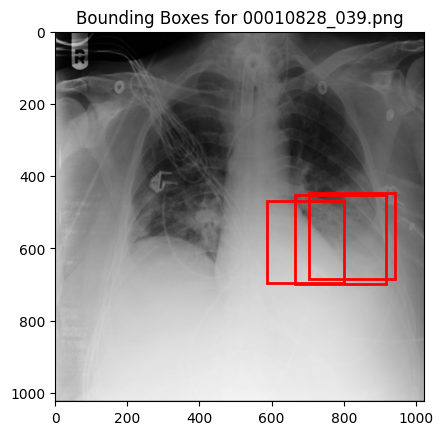

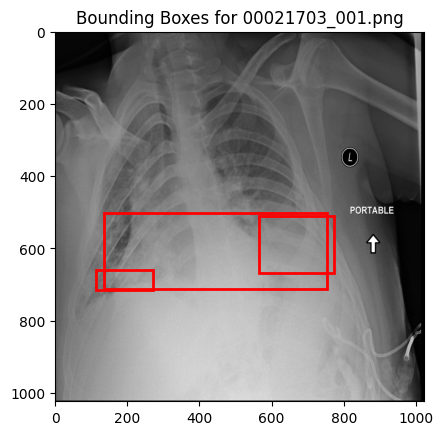

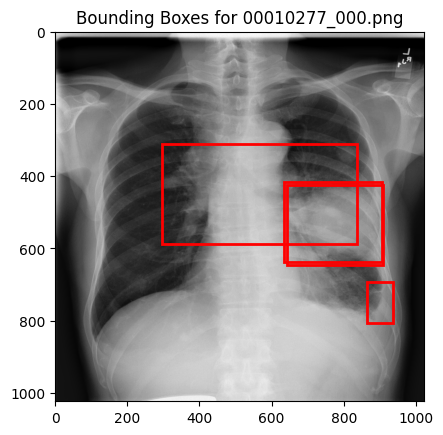

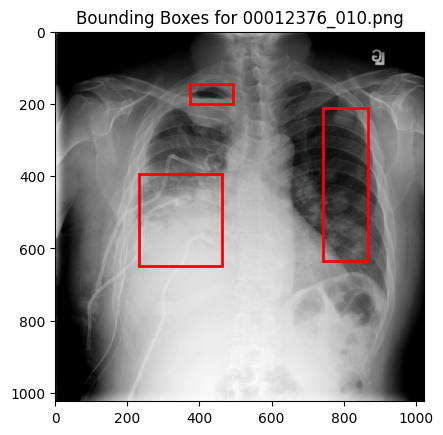

In [56]:
# Filter the DataFrame to include only those with multiple bounding boxes
multi_boxes = merged_df[merged_df['Image Index'].isin(['00010277_000.png', '00012376_010.png', '00021703_001.png', '00010828_039.png'])]

# Define the base path for the images
base_path = '/cluster/home/taheeraa/datasets/chestxray-14/images/'

# Loop through the unique images that have more than one bounding box
for image_index in multi_boxes['Image Index'].unique():
    # Load the image
    img_path = base_path + image_index
    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')
    
    # Get rows for the current image
    rows = multi_boxes[multi_boxes['Image Index'] == image_index]
    
    # Draw each bounding box
    for idx, row in rows.iterrows():
        # Create a rectangle patch
        rect = patches.Rectangle((row['x'], row['y']), row['w'], row['h'], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    # Display the image
    plt.title(f"Bounding Boxes for {image_index}")
    plt.show()


In [57]:
def hacky():    
    img_path = base_path + img_index

    # Define specific colors
    colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
    unique_labels = df_filtered['Finding Label'].unique()
    if len(unique_labels) > len(colors_list):
        print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
    label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

    img = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')

    # Draw each bounding box with its corresponding label
    for idx, row in df_filtered.iterrows():
        # Extract coordinates and label
        x, y, w, h = row['x'], row['y'], row['w'], row['h']
        label = row['Finding Label']
        color = label_color_map[label]

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add text with a background color matching the bounding box
        ax.text(x, y, label, verticalalignment='top', color='black', fontsize=8, weight='bold', 
                bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # Display the image
    plt.title(f"{img_index}.png")
    plt.show()

In [58]:
image_index_counts_df.head(20)

,Image Index,Count
204,00010277_000.png,4
279,00012376_010.png,3
633,00021703_001.png,3
220,00010828_039.png,3
327,00013659_019.png,3
113,00005066_030.png,3
598,00020482_032.png,3
170,00008814_010.png,3
506,00018253_059.png,3
516,00018427_004.png,3


# Inference with gradcam
00021703_001, 00005066_030, 00027441_002

In [59]:
img_id = "00021703_001"
img_index = f"{img_id}.png"
df_filtered = merged_df[merged_df['Image Index'] == img_index]
df_filtered

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8,Finding Labels,...,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,filepath
315,00021703_001.png,Effusion,563.768889,511.184601,208.213333,155.875556,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
469,00021703_001.png,Infiltrate,113.208889,659.095712,158.151111,55.751111,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...
973,00021703_001.png,Atelectasis,136.362674,500.811858,616.675556,212.764444,NaN,NaN,NaN,Effusion|Infiltration|Atelectasis,...,21703,25,M,AP,3056,2544,0.139,0.139,NaN,/cluster/home/taheeraa/datasets/chestxray-14/i...


## loading model

In [60]:
pretrained_weights = "/cluster/home/taheeraa/code/master-thesis/01-multi-label/output/2024-05-23-13:36:36-fine-tuned-swin/swin_base_simmim_run_0.pth.tar"
checkpoint = torch.load(pretrained_weights)
state_dict = checkpoint['state_dict']

In [61]:
num_labels = 14
model = timm.create_model('swin_base_patch4_window7_224', num_classes=num_labels)
msg = model.load_state_dict(state_dict, strict=False)
print('Loaded with msg: {}'.format(msg))

Loaded with msg: <All keys matched successfully>


## prepare data

In [62]:
def load_and_preprocess_images(image_paths,normalize="chestx-ray"):
    if normalize.lower() == "imagenet":
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = transforms.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
        
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to the same size expected by the model
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert the image to a tensor
        normalize
    ])
    images = [transform(Image.open(path).convert('RGB')) for path in image_paths]
    batch = torch.stack(images)  # Stack images into a single batch
    return batch

img_filenames = [f'{img_index}']
img_paths = [f"{images_path}/{filename}" for filename in img_filenames]

input_tensor = load_and_preprocess_images(img_paths)

## model inference

In [63]:
def predict(model, batch):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Turn off gradients to speed up this part
        logits = model(batch)  # Forward pass
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities for multilabel classification
    return probabilities

# Perform inference
probabilities = predict(model, input_tensor)

## prediction

In [64]:
import torchvision.transforms.functional as F

def plot_images_with_predictions(image_paths, labels, predictions, img_size):
    # Number of images
    num_images = len(image_paths)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(10, num_images * 5))
    
    # Flatten the axes array for easy iteration if only one row exists
    if num_images == 1:
        axes = [axes]
    
    # Loop through images, predictions, and the corresponding axes
    for idx, (path, ax) in enumerate(zip(image_paths, axes)):
        # Open and resize image
        image = Image.open(path).convert('RGB')
        image = F.resize(image, (img_size, img_size))
        
        # Display the image
        ax.imshow(image)
        ax.axis('off')  # Turn off axis
        
        # Get predicted labels
        predicted_labels = [label for label, pred in zip(labels, predictions[idx]) if pred == 1]
        
        # Set title with predicted labels
        ax.set_title("Predicted: " + ", ".join(predicted_labels))
    
    plt.tight_layout()
    plt.show()

# Convert probabilities to binary predictions based on a threshold
threshold = 0.2
print(probabilities)
predicted_labels = (probabilities > threshold).int()
print(predicted_labels)

# Now plot the images with their predicted labels
#plot_images_with_predictions(img_paths, labels, predicted_labels, img_size=224)

indices = torch.nonzero(predicted_labels == 1)
pred_indices = indices[:, 1]
pred_indices = pred_indices.tolist()

pred_labels = [labels[i] for i in pred_indices]
print(f"{pred_indices}: {pred_labels}")

tensor([[0.5605, 0.0081, 0.2558, 0.3114, 0.0143, 0.0096, 0.0234, 0.0248, 0.1391,
         0.0067, 0.0056, 0.0022, 0.0109, 0.0009]])
tensor([[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
[0, 2, 3]: ['Atelectasis', 'Effusion', 'Infiltration']


## looking at xai

In [65]:
#target_layer = model.norm
target_layer = model.layers[-1].blocks[-1].attn
classifier = model.head

img_path = base_path + img_index
img_pil = Image.open(img_path)
if len(pred_indices) == 0:
    targets = [ClassifierOutputTarget(1)]
else:
    targets = [ClassifierOutputTarget(i) for i in pred_indices]
input_tensor.size()

torch.Size([1, 3, 224, 224])

In [78]:
def reshape_transform(tensor, height=6, width=8):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255

cam = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

grayscale_cam = cam(input_tensor=input_tensor,
                    targets=targets,
                    eigen_smooth=True,
                    aug_smooth=True)

grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)

RuntimeError: shape '[1, 7, 7, 1024]' is invalid for input of size 49152

In [79]:
from timm.models import swin_base_patch4_window7_224_in22k
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
def reshape_transform(tensor, height=6, width=8):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layer = model.layers[-1].blocks[-1].norm1

cam = GradCAMPlusPlus(model=model, 
                      target_layer=target_layer, 
                      reshape_transform=reshape_transform)

rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], 
                                          std=[0.5, 0.5, 0.5]).cuda()
grayscale_cam = cam(input_tensor=input_tensor,
                    target_category=0,
                    eigen_smooth=True,
                    aug_smooth=True)

grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth" to /cluster/home/taheeraa/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22k.pth
Exception ignored in: <function BaseCAM.__del__ at 0x149a75ddd8b0>
Traceback (most recent call last):
  File "/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pytorch_grad_cam/base_cam.py", line 196, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAMPlusPlus' object has no attribute 'activations_and_grads'


TypeError: __init__() got an unexpected keyword argument 'target_layer'

## comparing

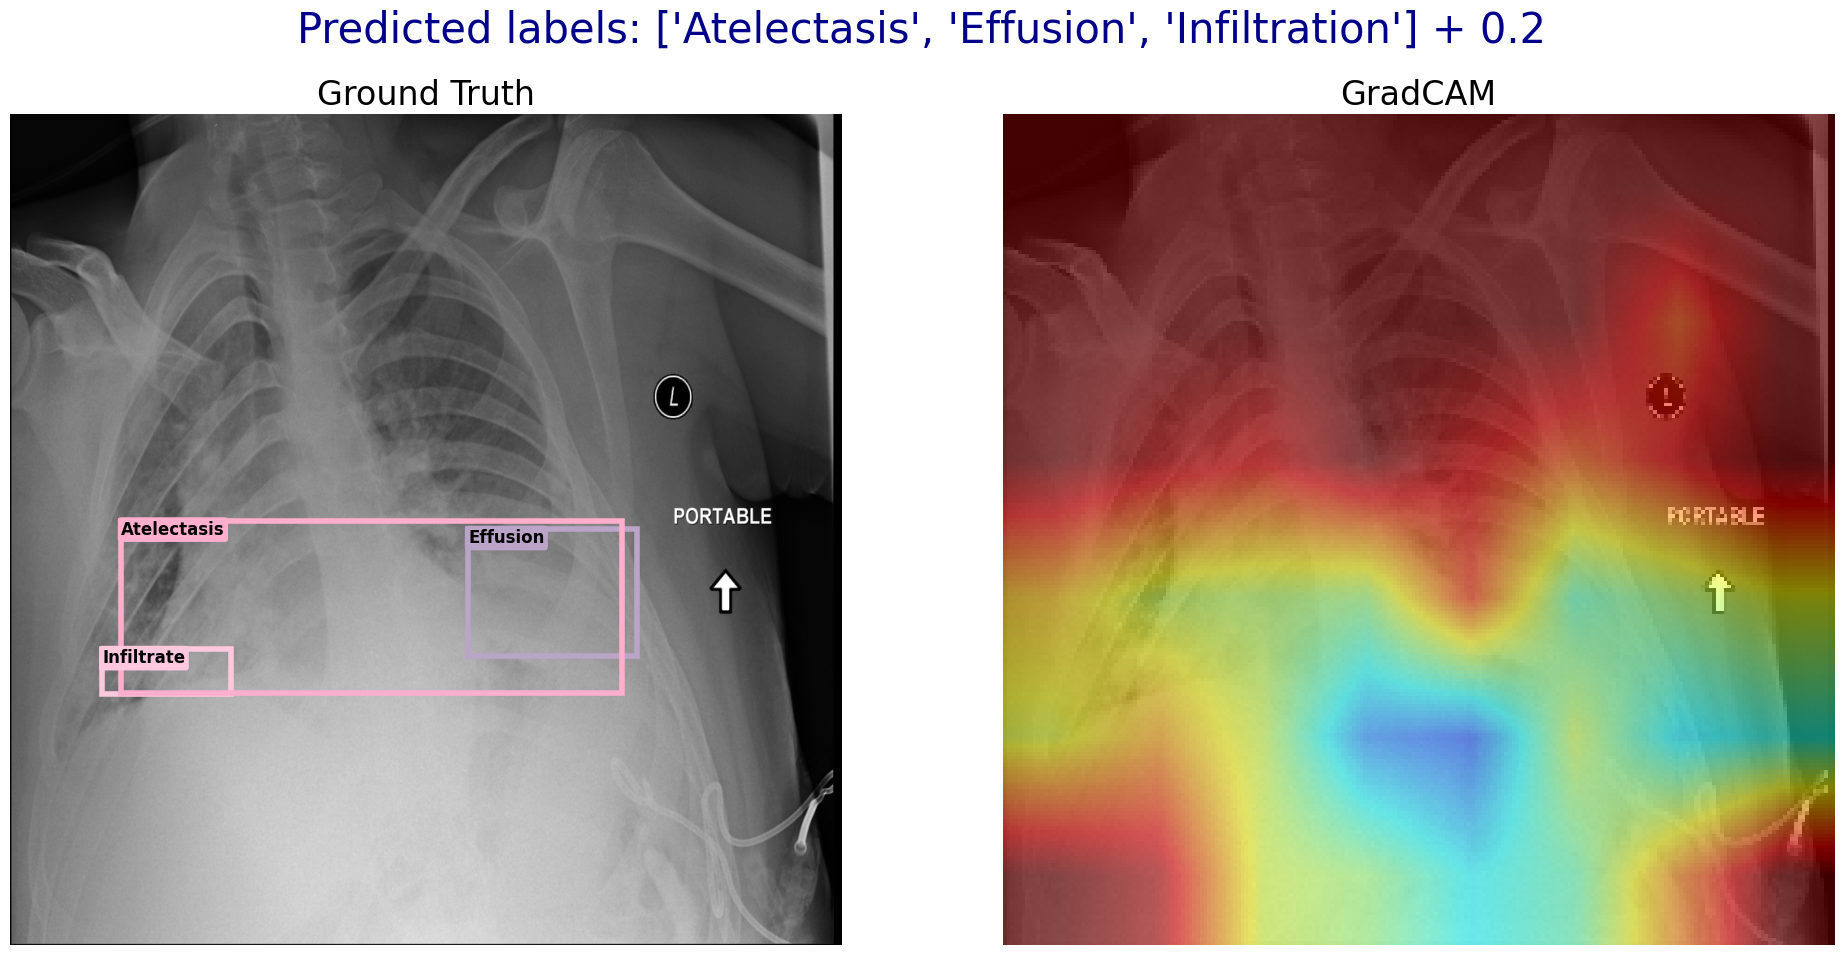

In [76]:
# Define specific colors
colors_list = ['#BAA4C7', '#FFC8DD', '#FFAFCC', '#BDE0FE']
unique_labels = df_filtered['Finding Label'].unique()
if len(unique_labels) > len(colors_list):
    print("Warning: There are more unique labels than provided colors. Some labels will have the same color.")
label_color_map = {label: colors_list[i % len(colors_list)] for i, label in enumerate(unique_labels)}

# Open the image
img = Image.open(img_path)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# First subplot: Image with bounding boxes
ax1 = axs[0]
ax1.imshow(img, cmap='gray')

# Draw each bounding box with its corresponding label
for idx, row in df_filtered.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    label = row['Finding Label']
    color = label_color_map[label]
    rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x, y, label, verticalalignment='top', color='black', fontsize=12, weight='bold', 
             bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

ax1.set_title("Ground Truth", fontsize=24)
ax1.axis('off')

# Second subplot: CAM image
ax2 = axs[1]
ax2.imshow(cam_image)  # Adjust this if 'cam_image' is not in RGB format
ax2.axis('off')
ax2.set_title("GradCAM", fontsize=24)

# Add a subtitle for the entire figure
fig.suptitle(f"Predicted labels: {pred_labels} + {threshold}", fontsize=30, color='darkblue')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect if the subtitle overlaps with the titles

# Save the figure
plt.savefig(f"gt_cam/{img_id}.png")

# Show the plot if needed (not necessary if saving)
plt.show()


## Look at more gradcams, which gives the best explanations?

In [68]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

def generate_cam_images(model, input_tensor, target_layers, types_of_cam, targets):
    cams = {
        'GradCAM': GradCAM,
        'HiResCAM': HiResCAM,
        'ScoreCAM': ScoreCAM,
        'GradCAMPlusPlus': GradCAMPlusPlus,
        'AblationCAM': AblationCAM,
        'XGradCAM': XGradCAM,
        'EigenCAM': EigenCAM,
        'FullGrad': FullGrad
    }

    images = []
    for cam_name in types_of_cam:
        cam_type = cams[cam_name]
        cam = cam_type(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        # Normalize input_tensor for visualization
        img_for_vis = input_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
        img_for_vis = img_for_vis - img_for_vis.min()  # Shift to have lowest value at 0
        img_for_vis = img_for_vis / img_for_vis.max()  # Scale to max value of 1

        # Create CAM image
        cam_image = show_cam_on_image(img_for_vis, grayscale_cam, use_rgb=True)
        images.append((cam_name, cam_image))

    return images